# Simulate gamma ray sources in galaxy

In [12]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm
n = 1000 #Number of spaces in grid (r,z,flux)
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
#From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.1
Rsun = 8.3
hb = 10 #This is considered as high latitude

#Trheshold of fermi, from 3fgl/3fhl? paper
fermi_thres = 5e-10#min_3fgl_high_lat 
flux_logspace = np.logspace(-12,-6,n)
minflux,maxflux=-13,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.
lranges = [(-180,180),(-90,90),(-20,20)]
branges = [(-20,20),(-10,10),(-5,5),(-1,1)]

In [2]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))
def convertlb_px(l,b):
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

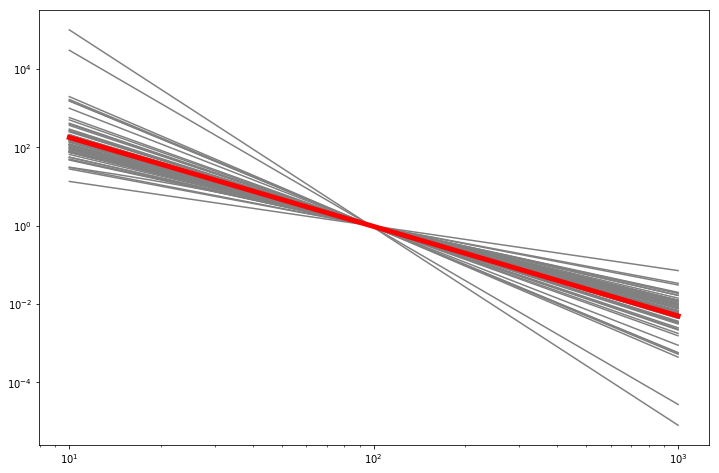

In [44]:
#Load 3fgl
file_3fgl = 'gll_psc_v16.fit'
file_3fhl ='gll_psch_v13.fit'
try:
    fgl=True
    data = fits.getdata(file_3fgl)
except:
    fgl = False
    print "3fgl data not available"
try:
    fhl=True
    data_fhl = fits.getdata(file_3fhl)
except:
    fhl=False
    print "3fhl data not available"
if fgl:
    tb = Table(data)
    cls = np.asarray(tb['CLASS1'].tolist())
    cls = np.char.lower(np.char.rstrip(cls, ' ')) #lower, take SNR and snr
    lat = tb['GLAT']
    lon = tb['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask = (cls=='psr') | (cls =='pwn') | (cls=='snr') | (cls=='spp')# | ((cls=='') & (np.abs(lat)<10))
    gal = tb[gal_mask]
    snr_mask = (cls=='snr')|(cls=='pwn')|(cls=='spp')
    psr_mask = cls=='psr'
#    pwn_mask = cls=='pwn'
#    spp_mask = cls=='spp'
    snr = tb[snr_mask]
    tev =snr['ASSOC_TEV']
    snr_tev = snr[np.char.rstrip(tev, ' ')!='']
    
    psr = tb[psr_mask]
    lat_gal = gal['GLAT'] #l,b of gal sources
    lon_gal = gal['GLON']
    lon_gal[lon_gal>180]-=360
    flux_3fgl = gal['Flux1000']
    lat_snr = snr['GLAT']
    lon_snr = snr['GLON']
    lat_psr = psr['GLAT']
    lon_psr = psr['GLON']
    flux_3fgl_snr = tb[snr_mask]['Flux1000'] 
    flux_3fgl_psr = tb[psr_mask]['Flux1000']
    
    total_flux_3fgl_snr = np.sum(flux_3fgl_snr)
    total_flux_3fgl_psr = np.sum(flux_3fgl_psr)
    
    #spectra
    E3fgl_bins = np.logspace(-1,2,101)
    E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
    E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
    spec_3fgl = catalog_spect.get_spec(file_3fgl)
    max_spec_3fgl = np.amax(spec_3fgl,axis=1)
    spec_3fgl = spec_3fgl/max_spec_3fgl[:,None] #Normalize to get average spectrum not depended on total flux
    spec_3fgl_gal = spec_3fgl[gal_mask]
    
    ##Split into source classes    
 #   spsnr = spec_3fgl[snr_mask]
 #   for sp in spsnr:
  #      plt.loglog(E3fgl,E3fgl**2*sp,color='gray')
  #  #Take the mean spectra of log of spectra 3fgl
    def mean_log(spec):
        meanlog = np.mean(np.log10(spec),axis=0)
        return 10**meanlog
        
    spec_3fgl_snr = mean_log(spec_3fgl[snr_mask])

   # plt.loglog(E3fgl,E3fgl**2*spec_3fgl_snr,color='red',linewidth=7)
    spec_3fgl_psr = mean_log(spec_3fgl[psr_mask])
    
    high_lat_mask_3fgl = np.abs(lat_gal)>=hb
    hb_mask_3fgl_snr = np.abs(lat_snr)>=hb
    hb_mask_3fgl_psr = np.abs(lat_psr)>=hb

if fhl:
    tb_fhl= Table(data_fhl)
    cls_fhl = np.asarray(tb_fhl['CLASS'].tolist())
    cls_fhl = np.char.lower(np.char.rstrip(cls_fhl, ' '))
    lat_fhl = tb_fhl['GLAT']
    lon_fhl = tb_fhl['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask_fhl = (cls_fhl=='psr') | (cls_fhl =='pwn') | (cls_fhl=='snr') | (cls_fhl=='spp')# | ((cls_fhl=='') & (np.abs(lat_fhl)<10))
    gal_fhl = tb_fhl[gal_mask_fhl]

    
    snr_mask = (cls_fhl=='snr')|(cls_fhl=='pwn')|(cls_fhl=='spp')
    psr_mask = cls_fhl=='psr'
   # pwn_mask = cls_fhl=='pwn'
   # spp_mask = cls_fhl=='spp'
    
    lat_gal_fhl = gal_fhl['GLAT'] #l,b of gal sources
    lon_gal_fhl = gal_fhl['GLON']
    lon_gal_fhl[lon_gal_fhl>180]-=360
    #spectra
    #TODO 
    E3fhl = np.logspace(1,3,100)#GeV
    spec_3fhl = catalog_spect.get_spec(file_3fhl)
    max_spec_3fhl = np.amax(spec_3fhl,axis=1)
    max_spec_3fhl = spec_3fhl[:,np.argmin(E<30)]
    spec_3fhl = spec_3fhl/max_spec_3fhl[:,None] #Normalize to get average spectrum not depended on total flux
    spec_3fhl_gal = spec_3fhl[gal_mask_fhl]
    spsr = spec_3fhl[snr_mask]
    for sp in spsr:
        plt.loglog(Efhl,sp,color='gray')
    
    spec_3fhl_snr = mean_log(spec_3fhl[snr_mask])
    spec_3fhl_psr = mean_log(spec_3fhl[psr_mask])
    plt.loglog(Efhl,spec_3fhl_snr,color='red',linewidth='5')
    
#log n log s

#    N_3fgl = np.zeros(n)

#Create log n log s plot, deprecated??
  #  for i,f in enumerate(flux_logspace):
  #      N_3fgl[i] = len(spec_3fgl[flux_3fgl > f])

dist_tb = [3.5,2,2,1.5,0.29,0.2,6.6,5.2,None,6.5,None,8.6,None,1,7.9,11.5,None,8.3,2,6,3.7,3.9,4,6.6,None,4.3,None,0.8,3.4]
dist_tb = np.array(dist_tb)
mask_dist = dist_tb!=None
L_tev = snr_tev['Flux1000'][mask_dist]*(4*np.pi*(dist_tb[mask_dist]*kpc)**2).tolist()

In [23]:
#Do the simulation monte carlo
def mc_smpl(a=2,N=1000,Lmin=3e34,Lmax=1e40,alpha=alp,beta=bet,H=H):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth"""
    N = int(N) #no samples just to be sure 

    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)
    
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)

    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi

    ##My function, that does conserve flux, but does it always work?
    #mp = makemap.makemap(l,b,flux_data,0.5)
        
    high_lat_mask = np.abs(b)>hb
    flux_hb = flux_data[high_lat_mask] 
    #histogram for normalization
    
    hist = np.histogram(flux_data,bins=bins)[0]
    #Fluxes at different regions

    
    flux_cutoff = 1e-12 ##This...
    #fermi_thres = 1e-10 
    dict_flux_lb = {}
    dict_flux_lb['lrange']=[]
    dict_flux_lb['brange']=[]
    dict_flux_lb['flux100']=[]
    for ll in lranges:
        mask_l = (l>=ll[0])&(l<=ll[1])
        for bb in branges:
            mask_b = (b>=bb[0])&(b<=bb[1])
            total_flux_lb = flux_data[mask_l&mask_b]
            flux_unresolved = total_flux_lb[total_flux_lb<fermi_thres]
            flux_unresolved[flux_unresolved<flux_cutoff]=0
            dict_flux_lb['lrange'].append(ll)
            dict_flux_lb['brange'].append(bb)
            dict_flux_lb['flux100'].append(np.sum(flux_unresolved))
    
    #print dict_flux_lb['lrange']     
    #total_flux = np.sum(flux_data)
    
    return hist,dict_flux_lb

In [24]:
##Flux for l,b. 
hist,dct = mc_smpl(2,30000,1e34,1e40,alp,bet)


print dct

#nside = 128
#npix = hp.nside2npix(nside)
#pix = hp.ang2pix(nside,l,b,lonlat=True)
#hp_map = np.zeros(npix)
#np.add.at(hp_map,pix,flx) #To make sure recurring pixels are added on top of each other
#print np.sum(hp_map)
#mp[mp==0]=1e-14
#mp = np.log10(mp)
#fig = plt.figure(figsize=(25,10))
#ax = fig.add_subplot(111)
#ax.set_xticks([0,180,360,540,720])
#ax.set_xticklabels([-180,-90,0,90,180])
#ax.set_yticks([0,90,180,270,360])
#ax.set_yticklabels([90,45, 0,-45,-90])
#ax.set_xlabel('l')
#ax.set_ylabel('b')
#im = ax.imshow(mp[140:221,:],cmap='hot',vmin=-14,vmax=-5)
#fig.colorbar(im,orientation='horizontal',shrink=0.5)

{'flux100': [2.8917743343162004e-07, 2.7855776635874844e-07, 2.5247417015930003e-07, 1.2533989022440082e-07, 2.6773895558819324e-07, 2.6020304572645177e-07, 2.387779998031007e-07, 1.2052057042112011e-07, 1.3436448077159187e-07, 1.316426438655234e-07, 1.2168649077343854e-07, 6.4605439347268374e-08], 'lrange': [(-180, 180), (-180, 180), (-180, 180), (-180, 180), (-90, 90), (-90, 90), (-90, 90), (-90, 90), (-20, 20), (-20, 20), (-20, 20), (-20, 20)], 'brange': [(-20, 20), (-10, 10), (-5, 5), (-1, 1), (-20, 20), (-10, 10), (-5, 5), (-1, 1), (-20, 20), (-10, 10), (-5, 5), (-1, 1)]}


0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100% done
{'flux100': [3.6387290876133132e-07, 3.5273588583267846e-07, 3.3407219953999167e-07, 2.1919175926148777e-07, 3.311156164100281e-07, 3.2394230530207966e-07, 3.1157093724868685e-07, 2.0911867690366668e-07, 1.8419680859290158e-07, 1.8180794286239729e-07, 1.7694677864685515e-07, 1.2299909153725509e-07], 'lrange': [(-180, 180), (-180, 180), (-180, 180), (-180, 180), (-90, 90), (-90, 90), (-90, 90), (-90, 90), (-20, 20), (-20, 20), (-20, 20), (-20, 20)], 'brange': [(-20, 20), (-10, 10), (-5, 5), (-1, 1), (-20, 20), (-10, 10), (-5, 5), (-1, 1), (-20, 20), (-10, 10), (-5, 5), (-1, 1)]}


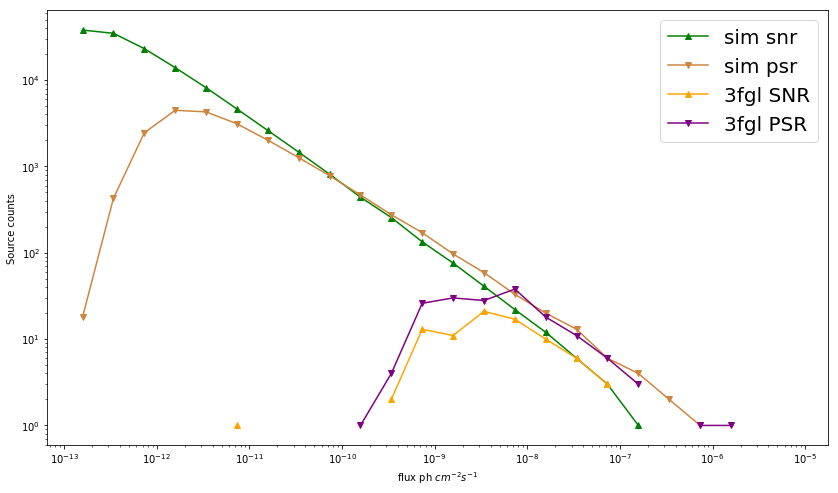

In [26]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources

Nsnr = 150000
Npsr = 20000
Nsmpl = 10

fluxes_snr = []
fluxes_psr = []
hist_snr = np.zeros((Nsmpl,len(bins_mean)))
hist_psr = np.zeros((Nsmpl,len(bins_mean)))

for i in range(Nsmpl):
    if i%(Nsmpl/10.)==0:
        print 100*i/float(Nsmpl),"% done"
    #fluxes_snr[i,:]=(mc_smpl(1.9,Nsnr,1e33,5e38,alp_snr,bet_snr)[0])
    #fluxes_psr[i,:]=(mc_smpl(1.7,Npsr,1e34,1e40,alp,bet)[0])
    hist_snr[i,:],dict_snr = mc_smpl(1.8,Nsnr,1e33,4e38,alp_snr,bet_snr,H_snr)
    hist_psr[i,:],dict_psr = mc_smpl(1.7,Npsr,1e34,1e40,alp,bet)
    fluxes_snr.append(dict_snr['flux100'])
    fluxes_psr.append(dict_psr['flux100'])
    ll = dict_snr['lrange']
    bb = dict_snr['brange']
print "100% done"

ave_flux_snr = np.average(fluxes_snr,axis=0)
ave_flux_psr = np.average(fluxes_psr,axis=0)

f1,ax1 = plt.subplots(1,figsize=(14,8))
ax1.loglog(bins_mean,np.rint(np.mean(hist_snr,axis=0)),marker='^',label='sim snr', color='green')
ax1.loglog(bins_mean,np.rint(np.mean(hist_psr,axis=0)),marker='v',label='sim psr', color='peru')
if fgl:

    hist_3fgl_snr = np.histogram(flux_3fgl_snr,bins=bins)[0]
    hist_3fgl_psr = np.histogram(flux_3fgl_psr,bins=bins)[0]
    ax1.loglog(bins_mean,hist_3fgl_snr,marker='^', color='orange', label='3fgl SNR')
    ax1.loglog(bins_mean,hist_3fgl_psr,marker='v', color='purple', label='3fgl PSR') 
    
ax1.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
ax1.set_ylabel('Source counts')
ax1.legend(prop={'size':20})

In [16]:
#Get total diffuse spectra
import open_dat
from scipy.optimize import curve_fit
try:
    datFile=open_dat.open_dat('r5_fulldisk_spectra.dat')
    diff = True
except Exception as e:
    diff = False
    print "No r5 file"
    print e
if diff:
    #Get gas maps at ~2GeV
    mp_gas = np.loadtxt('total_gas_flux2GeV.dat')*7.6e-5/1.91 #sr,dE?
    #mp_unresolved = mp[140:221,:]
   # mp_unresolved[mp_unresolved<=fermi_thres]=0
    #total_unres_flux = np.sum(mp_unresolved)
   # print total_unres_flux
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
            
    sr =0.25*np.radians(1)**2*(720*81)
    total_gas_spec =sr*(total_gas_spec/deltaE)[mask_diff]
    total_gas_err = sr*(total_gas_err/deltaE)[mask_diff]
    
    E_diff = E_diff[mask_diff]
    plotfunc = lambda E,a,b: b*E**-a
    fitfunc = lambda E,a,b: b-a*E
    fit,cov = curve_fit(fitfunc,np.log10(E_diff),np.log10(total_gas_spec),sigma=total_gas_err/total_gas_spec)
    diff_index = fit[0]
    
    ##Make gas maps for some energies
    Etest = [2,10,30,50,100,200,500,1000]
    gas_3D = np.zeros((len(Etest),mp_gas.shape[0], mp_gas.shape[1]))
    for i in range(len(Etest)):
        gas_3D[i,:,:]=mp_gas*(Etest[i]/Etest[0])**-diff_index
        #fig = plt.figure(figsize=(15,7))
       # ax = fig.add_subplot(111)
       # ax.set_title("Energy: %s GeV"%Etest[i])
       # ax.set_xticks([0,180,360,540,720])
       # ax.set_xticklabels([-180,-90,0,90,180])
       # ax.set_yticks([0,40,80])
       # ax.set_yticklabels([20,0,-20])
       # ax.set_xlabel('l')
       # ax.set_ylabel('b')
       # im = ax.imshow(np.log10(gas_3D[i,:,:]),cmap='hot',vmin=-15,vmax=-8)
    #fig.colorbar(im,orientation='horizontal',shrink=0.5)


    
    # plt.errorbar(E_diff,E_diff**2*total_gas_spec,yerr=E_diff**2*total_gas_err,markersize=4,marker='.',linestyle='')
   # plt.plot(E_diff,E_diff**2*plotfunc(E_diff,fit[0],10**fit[1]))

   # plt.xscale('log',nonposx='clip')
   # plt.yscale('log',nonposy='clip')

[  8.95288955e-07   7.65864329e-07   6.54363504e-07   5.58425070e-07
   4.75980714e-07   4.05221441e-07   3.44567322e-07   2.92640459e-07
   2.48240858e-07   2.10324937e-07   1.77986425e-07   1.50439405e-07
   1.27003281e-07   1.07089499e-07   9.01898044e-08   7.58658996e-08
   6.37403420e-08   5.34885441e-08   4.48317586e-08   3.75309349e-08
   3.13813484e-08   2.62079124e-08   2.18610927e-08   1.82133534e-08
   1.51560689e-08   1.25968466e-08   1.04572073e-08   8.67058107e-09
   7.18057627e-09   5.93948794e-09   4.90701426e-09   4.04915353e-09
   3.33725796e-09   2.74722305e-09   2.25879425e-09   1.85497489e-09
   1.52152119e-09   1.24651234e-09   1.01998497e-09   8.33622769e-10
   6.80493488e-10   5.54826234e-10   4.51823287e-10   3.67501268e-10
   2.98557291e-10   2.42256328e-10   1.96336564e-10   1.58929988e-10
   1.28495857e-10   1.03765028e-10   8.36934547e-11   6.74233912e-11
   5.42510687e-11   4.35998114e-11   3.49977022e-11   2.80590563e-11
   2.24690752e-11   1.79711530e-11

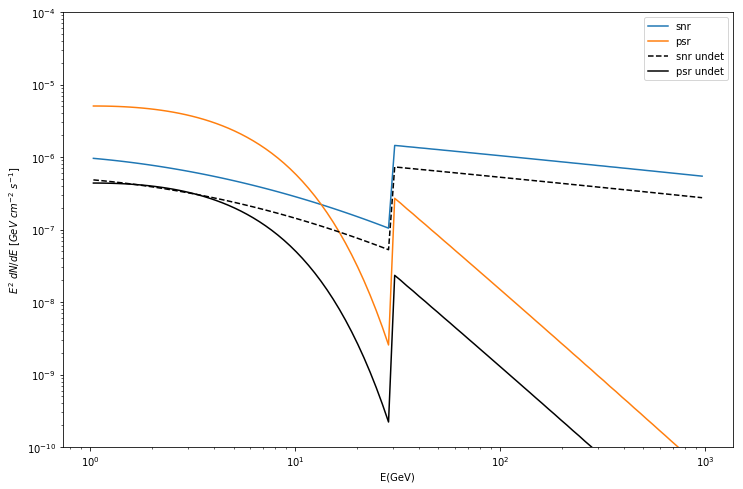

In [47]:
#Take the average spectra of 3fgl+3fhl and give that spectra to the simulated sources
#Plot the spectra from 1-1000GeV
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
fhl_fgl = np.zeros_like(E)
#mask_Efhl = Efhl>100
mask_E3fhl = E>30
mask_E = (E>=1)&(E<=100)
if fgl and fhl:
    total_spec_3fgl = np.sum(spec_3fgl_gal,axis=0)
    total_spec_3fgl /= max(total_spec_3fgl) #normalize again
    total_spec_3fhl = np.sum(spec_3fhl_gal,axis=0)
    total_spec_3fhl /= max(total_spec_3fhl)
    
    #Interpolate spec from 1-1000 GeV
    def norm_spec(spec,flux,dE,mask):
        wrong_spec = spec*flux
        norm = np.sum(wrong_spec[mask]*dE[mask])
        return wrong_spec*flux/norm
    
    
    good_spec_3fgl_snr = norm_spec(spec_3fgl_snr,total_flux_3fgl_snr,E3fgl_dE,mask_E3fgl)
    good_spec_3fgl_psr = norm_spec(spec_3fgl_psr,total_flux_3fgl_psr,E3fgl_dE,mask_E3fgl)
    
    intp_3fgl_snr = np.interp(E,E3fgl,good_spec_3fgl_snr)
    intp_3fgl_psr = np.interp(E,E3fgl,good_spec_3fgl_psr)
    norm_snr = intp_3fgl_snr[np.argmin(E<30)]
    norm_psr = intp_3fgl_psr[np.argmin(E<30)]
    print intp_3fgl_snr
    print norm_snr
    print spec_3fhl_snr
    intp_3fhl_snr = np.interp(E,Efhl, spec_3fhl_snr*norm_snr*1.06)
    intp_3fhl_psr = np.interp(E,Efhl, spec_3fhl_psr*norm_psr*1.1)

    intp_3fgl_snr[mask_E3fhl] = intp_3fhl_snr[mask_E3fhl]
    intp_3fgl_psr[mask_E3fhl] = intp_3fhl_psr[mask_E3fhl]
    
    plt.loglog(E,E**2*intp_3fgl_snr, label='snr')
    plt.loglog(E,E**2*intp_3fgl_psr,label='psr')
    
   
    intp_3fgl_snr_normed = intp_3fgl_snr/np.max(intp_3fgl_snr)
    intp_3fgl_psr_normed = intp_3fgl_psr/np.max(intp_3fgl_psr)
   
    
    ##Normalize so that flux 1-100GeV is as simulated
    spec_sim_snr = norm_spec(intp_3fgl_snr_normed,ave_flux_snr[0],dE,mask_E)
    spec_sim_psr = norm_spec(intp_3fgl_psr_normed,ave_flux_psr[0],dE,mask_E)

   # spec_sim_snr = np.sum(ave_flux_snr[ave_flux_snr<=fermi_thres])*intp_3fgl_snr_normed*norm_snr
   # spec_sim_psr = np.sum(ave_flux_psr[ave_flux_psr<=fermi_thres])*intp_3fgl_psr_normed*norm_psr

    total_undet = spec_sim_snr+spec_sim_psr
    plt.loglog(E,E**2*spec_sim_snr,'k--',label='snr undet')
    plt.loglog(E,E**2*spec_sim_psr, 'k-', label='psr undet')

    if diff:
        diff_flux_1GeV = total_gas_spec[0]
        diffuse = diff_flux_1GeV*E**-diff_index
        #diffuse2 = diff_flux_1GeV*E**-2.3
        #plt.loglog(E,E**2*diffuse2,label='diffuse 2.3')
        #plt.loglog(E,E**2*diffuse,label='diffuse')
        #plt.loglog(E,E**2*(diffuse+total_undet),label='diffuse + undetected')
    plt.xlabel("E(GeV)")
    plt.ylabel(r"$E^2 \ dN/dE \ [GeV \ cm^{-2} \ s^{-1}]$")
  #  plt.xlim([0.1,1e3])
    plt.ylim([1e-10,1e-4])
    plt.legend()

(1e-09, 1e-05)

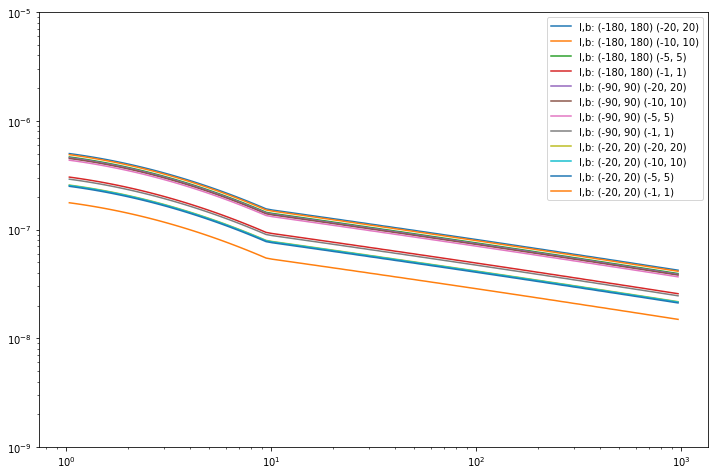

In [32]:
### Plot spectra for lranges and branges, diffuse and ps

for i in range(len(ave_flux_snr)):
    spec_sim_snr = norm_spec(intp_3fgl_snr_normed,ave_flux_snr[i],dE,mask_E)
    spec_sim_psr = norm_spec(intp_3fgl_psr_normed,ave_flux_psr[i],dE,mask_E)
    plt.loglog(E,E**2*spec_sim_snr,label="l,b: %s %s"%(ll[i],bb[i]))
    
plt.legend()
plt.ylim([1e-9,1e-5])

In [ ]:
##unresolved 3d map

mp_unresolved_3D = np.zeros((len(Etest),mp_unresolved.shape[0],mp_unresolved.shape[1]))
for i in range(len(Etest)):
    mp_unresolved_3D[i,:,:]= mp_unresolved*(Etest[i]/Etest[0])**-2.2
    
    
#Test some l,b ranges, inner galaxy
lranges = [(-180,180),(-90,90),(-40,40),(-20,20),(-10,10)]
branges = [(-20,20),(-10,10),(-5,5),(-1,1)]

def convertlb_px(l,b):
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

for ll in lranges:
    lmin,lmax = ll
    print lmin,lmax
    lmin = convertlb_px(lmin,0)[0]
    lmax = convertlb_px(lmax,0)[0]
    bmin = convertlb_px(0,20)[1]
    bmax = convertlb_px(0,-20)[1]
    unres_ps_flux = np.sum(mp_unresolved_3D[0,bmin:bmax,lmin:lmax])
    gas_flux = np.sum(gas_3D[0,bmin:bmax,lmin:lmax])
    print unres_ps_flux,gas_flux

In [ ]:
#Estimate contribution of flux from undetected sources

print "Percentage of flux in undetected and diffuse"
#Change from index 2.3->2.7 at 100GeV
def ratio(E,index1=2.5,index2=2.7):
    return E**-index1/E**-index2
test_E = [2,10,30,50,100,200,500,1000]

print "ratios"
for e in test_E:
    index_e = np.argmin(np.abs(E-e))
    #index_e = np.argmax(index_e)
    undet_flux = total_undet[index_e]

    diff_flux = diffuse[index_e]

    print "at %.0f GeV"%e
    print "%% flux in undetected sources vs diffuse emission = %.1f %%\n"%(100*undet_flux/diff_flux)
    #print "Need: at %.0f GeV: %.1f %%"%(e,ratio(e)*100)